# Base Model

A feedforward multilayer ANN for classification task of CVEs - in their vectorization format - into their corresponding CWE.

To do:
- Transform CVE data into vector format
- Train the model!

### Import the necessary libraries

Install libraries

In [1]:
# !pip install Pinecone
# !pip install torch
# !pip install transformers
# !pip install peft

Import libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

from pinecone import Pinecone

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split

from peft import PeftModel
from transformers import AutoTokenizer, AutoModelForMaskedLM

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder

### Import data for supervised learning

Import data in the csv folders

In [4]:
number_of_cwes = 1427

### Train data
# Step 1: Load the CSV file
file_path_train = "train.csv"
data_train = pd.read_csv(file_path_train)

# Step 2: Separate X and Y
X_train = [s[:-1] if s.endswith('.') else s for s in data_train.iloc[:, 1].values]  # Keep only the CVE description
Y_train = data_train.iloc[:, 2:].values  # Latter two columns for targets

# Extract numeric part from 'CWE-' using list comprehension and regex
numeric_cwe_train = np.array([int(re.search(r'CWE-(\d{1,4})', row[0]).group(1)) for row in Y_train])

# Create one-hot encoded matrix
one_hot_encoded_fixed_train = np.zeros((len(numeric_cwe_train), number_of_cwes))  # Initialize with zeros

# Set the position corresponding to the CWE ID to 1
for i, cwe_id in enumerate(numeric_cwe_train):
    one_hot_encoded_fixed_train[i, cwe_id-1] = 1  # Set the position `cwe_id - 1` to 1

### Test data
file_path_test = "test.csv"
data_test = pd.read_csv(file_path_test)

# Step 2: Separate X and Y
X_test = [s[:-1] if s.endswith('.') else s for s in data_test.iloc[:, 1].values] # Keep only the CVE description
Y_test = data_test.iloc[:, 2:].values  # Latter two columns for targets

# Extract numeric part from 'CWE-' using list comprehension and regex
numeric_cwe_test = np.array([int(re.search(r'CWE-(\d{1,4})', row[0]).group(1)) for row in Y_test])

# Create one-hot encoded matrix
one_hot_encoded_fixed_test = np.zeros((len(numeric_cwe_test), number_of_cwes))  # Initialize with zeros

# Set the position corresponding to the CWE ID to 1
for i, cwe_id in enumerate(numeric_cwe_test):
    one_hot_encoded_fixed_test[i, cwe_id-1] = 1  # Set the position `cwe_id - 1` to 1

Loading model for embedding the CVEs description

In [7]:
MODEL_VERSION = 1

base_model_name = "bert-base-uncased"
adapter_path = f"./models/model_{MODEL_VERSION}/fine_tuned_lora_mlm"

tokenizer = AutoTokenizer.from_pretrained(base_model_name)

base_model = AutoModelForMaskedLM.from_pretrained(base_model_name, output_hidden_states=True)
model_embedding = PeftModel.from_pretrained(base_model, adapter_path)

/home/guilherme/.local/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:774: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
# Set a version number for the model to manage multiple versions effectively
MODEL_VERSION = 1

base_model_name = "bert-base-uncased"
adapter_path = f"/home/guilherme/Documents/MC959/Projeto/models/model_{MODEL_VERSION}/fine_tuned_lora_mlm"

base_model = AutoModelForMaskedLM.from_pretrained(base_model_name)

model_embedding = PeftModel.from_pretrained(base_model, adapter_path)
tokenizer = AutoTokenizer.from_pretrained(base_model_name)

BertForMaskedLM has generative capabilities, as `prepare_inputs_for_generation` is explicitly overwritten. However, it doesn't directly inherit from `GenerationMixin`. From 👉v4.50👈 onwards, `PreTrainedModel` will NOT inherit from `GenerationMixin`, and this model will lose the ability to call `generate` and other related functions.
  - If you're using `trust_remote_code=True`, you can get rid of this warning by loading the model with an auto class. See https://huggingface.co/docs/transformers/en/model_doc/auto#auto-classes
  - If you are the owner of the model architecture code, please modify your model class such that it inherits from `GenerationMixin` (after `PreTrainedModel`, otherwise you'll get an exception).
  - If you are not the owner of the model architecture class, please contact the model code owner to update it.
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'c

Transform train and test data into their embedding format

In [9]:
# Função para codificar as entradas usando o modelo LoRA
def encoder(inputs):
    embeddings = []
    for input_text in inputs:
        # Tokenizar a entrada
        tokens = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True, max_length=128)

        # Certifique-se de que os tensores estejam na mesma device do modelo
        tokens = {key: val for key, val in tokens.items()}

        # Passar os tokens pelo modelo (incluindo os adaptadores LoRA)
        with torch.no_grad():
            outputs = model_embedding(**tokens)  # Chamada ao modelo
            # Extração do embedding da última camada oculta
            embedding = outputs.hidden_states[-1].mean(dim=1).squeeze().cpu().numpy()
            embeddings.append(embedding)

    return embeddings

# Generate embeddings for a list of CVE descriptions
embeddings_train = encoder(X_train)
embeddings_test = encoder(X_test)

In [14]:
print(len(embeddings_train))
print(len(Y_train))

2392
2392


### ANN Definition

Hyperparameters

In [15]:
input_size = 768          # Input vector size (V_CVE_size)
num_classes = number_of_cwes              # Number of output classes (N_CWE)
hidden_sizes = [256, 128, 64]    # Sizes of hidden layers
activation_function = nn.ReLU    # Activation function to be used
batch_size = 32                  # Batch size
learning_rate = 1e-3             # Learning rate
num_epochs = 100                  # Number of training epochs
dropout_prob = 0.5             # Dropout probability for regularization (not used!)

Neural network model

In [16]:
# Build the neural network model dynamically
layers = []

# Input layer
layers.append(nn.Linear(input_size, hidden_sizes[0]))
layers.append(activation_function())

# Hidden layers
for i in range(len(hidden_sizes) - 1):
    layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
    layers.append(activation_function())
    layers.append(nn.Dropout(dropout_prob))

# Output layer
layers.append(nn.Linear(hidden_sizes[-1], num_classes))
layers.append(nn.Softmax(dim=1))

# Create the sequential model
model = nn.Sequential(*layers)

In [17]:
print("Neural Network Model:")
print(model)

Neural Network Model:
Sequential(
  (0): Linear(in_features=768, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): ReLU()
  (4): Dropout(p=0.5, inplace=False)
  (5): Linear(in_features=128, out_features=64, bias=True)
  (6): ReLU()
  (7): Dropout(p=0.5, inplace=False)
  (8): Linear(in_features=64, out_features=1427, bias=True)
  (9): Softmax(dim=1)
)


Loss function

In [18]:
# Loss function definiton

loss_fn = nn.CrossEntropyLoss()

Optimization method

In [19]:
# Defining the optimization method
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### ANN training

Prepare data for training

In [28]:
num_samples = 10

X_train = torch.tensor(embeddings_train, dtype=torch.float32)
y_train = torch.tensor(one_hot_encoded_fixed_train, dtype=torch.float32)  # CrossEntropyLoss expects labels of type Long

# Create a TensorDataset from X_train and y_train
train_dataset = TensorDataset(X_train, y_train)

X_test = torch.tensor(embeddings_test, dtype=torch.float32)
y_test = torch.tensor(one_hot_encoded_fixed_test, dtype=torch.float32)  # CrossEntropyLoss expects labels of type Long

# Create a TensorDataset from X_train and y_train
test_dataset = TensorDataset(X_test, y_test)

# # Ensure no missing values
# if np.isnan(X_array).any():
#     print("Data contains NaN values. Removing rows with NaN values...")
#     # Create a mask for rows without NaNs
#     mask = ~np.isnan(X_array).any(axis=1)
    
#     # Filter X_array and y_array using the mask
#     X_array = X_array[mask]
#     y_array = y_array[mask]

# # Convert data to PyTorch tensors
# X_tensor = torch.tensor(X_array, dtype=torch.float32)
# y_tensor = torch.tensor(y_array, dtype=torch.long)  # CrossEntropyLoss expects labels of type Long

# # Define split proportions
# train_size = int(0.7 * len(full_dataset))
# test_size = int(0.3 * len(full_dataset))

# # Split the dataset
# train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Store data for training and the accuracy of the model

In [29]:
# Lists to store loss and accuracy for plotting
train_losses = []
train_accuracies = []
val_accuracies = []

Choose the GPU, if avaliable

In [30]:
# Check if CUDA is available and use the GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the GPU
model = model.to(device)

Training the model

In [36]:
for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for batch_X, batch_y in train_loader:
        # # Move the batch to the GPU
        # batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        # Convert one-hot encoded batch_y to class indices
        batch_y_indices = torch.argmax(batch_y, dim=1)  # Convert one-hot to class indices

        
        # Forward pass
        outputs = model(batch_X)
        # loss = loss_fn(outputs, batch_y)

        # Compute loss
        loss = loss_fn(outputs, batch_y_indices)  # Pass indices to loss function

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        # _, predicted = torch.max(outputs.data, 1)
        # total += batch_y.size(0)
        # correct += (predicted == batch_y).sum().item()

        # Get predicted class indices
        _, predicted = torch.max(outputs.data, 1)  # Outputs are of shape [batch_size, num_classes]
        
        # Calculate correct predictions
        total += batch_y_indices.size(0)
        correct += (predicted == batch_y_indices).sum().item()

    avg_train_loss = total_loss / len(train_loader)
    train_accuracy = 100 * correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # # Validation phase (removed because of time issues)
    # model.eval()
    # val_loss = 0
    # val_correct = 0
    # val_total = 0
    # with torch.no_grad():
    #     for val_X, val_y in val_loader:
    #         outputs = model(val_X)
    #         loss = loss_fn(outputs, val_y)
    #         val_loss += loss.item()
    #         _, predicted = torch.max(outputs.data, 1)
    #         val_total += val_y.size(0)
    #         val_correct += (predicted == val_y).sum().item()

    # avg_val_loss = val_loss / len(val_loader)
    # val_accuracy = 100 * val_correct / val_total
    # val_losses.append(avg_val_loss)
    # val_accuracies.append(val_accuracy)

    # Save the model after each epoch
    torch.save(model.state_dict(), "base_model.pth")

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, ')
          # f'Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')

Epoch [1/100], Train Loss: 7.2518, Train Acc: 1.25%, 
Epoch [2/100], Train Loss: 7.2505, Train Acc: 1.38%, 
Epoch [3/100], Train Loss: 7.2463, Train Acc: 1.84%, 
Epoch [4/100], Train Loss: 7.2518, Train Acc: 1.21%, 
Epoch [5/100], Train Loss: 7.2495, Train Acc: 1.55%, 
Epoch [6/100], Train Loss: 7.2503, Train Acc: 1.46%, 
Epoch [7/100], Train Loss: 7.2493, Train Acc: 1.55%, 
Epoch [8/100], Train Loss: 7.2486, Train Acc: 1.59%, 
Epoch [9/100], Train Loss: 7.2492, Train Acc: 1.55%, 
Epoch [10/100], Train Loss: 7.2479, Train Acc: 1.67%, 
Epoch [11/100], Train Loss: 7.2486, Train Acc: 1.59%, 
Epoch [12/100], Train Loss: 7.2489, Train Acc: 1.55%, 
Epoch [13/100], Train Loss: 7.2480, Train Acc: 1.63%, 
Epoch [14/100], Train Loss: 7.2475, Train Acc: 1.63%, 
Epoch [15/100], Train Loss: 7.2430, Train Acc: 2.26%, 
Epoch [16/100], Train Loss: 7.2404, Train Acc: 2.47%, 
Epoch [17/100], Train Loss: 7.2406, Train Acc: 2.38%, 
Epoch [18/100], Train Loss: 7.2406, Train Acc: 2.42%, 
Epoch [19/100], Tra

### ANN analysis

Data from training process

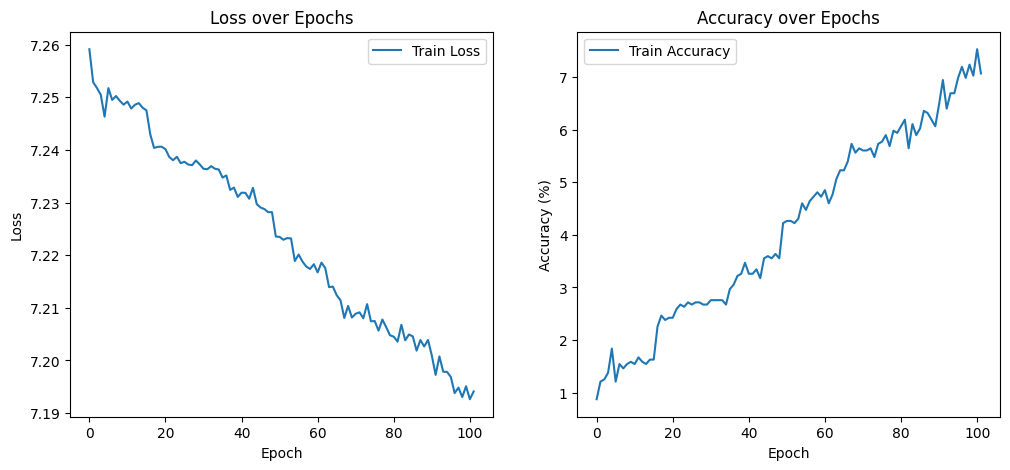

In [37]:
# Visualization of Loss and Accuracy

# Plot Loss over epochs
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy over epochs
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

Model final evaluation

In [41]:
# Evaluate on Test Data and Compute Performance Metrics

model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for test_X, test_y in test_loader:
        outputs = model(test_X)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(test_y.cpu().numpy())

# Compute metrics
test_accuracy = accuracy_score(all_labels, all_preds) * 100
precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

print(f'Test Accuracy: {test_accuracy:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

Save the base model

In [34]:
# Save the trained model
torch.save(model.state_dict(), "base_model.pth")
print("Model saved as 'base_model.pth'")

Model saved as 'base_model.pth'
